## **Install Packages:**

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-google-genai langchain_core langchain_community

## **Import Gemini Key:**

In [2]:
# For Colab, use this:
from google.colab import userdata
GEMINI_API_KEY = userdata.get("GEMINI_API_KEY")

## **Define Model:**

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

gemini_flash: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(
    model='gemini-1.5-flash',
    temperature=0,
    api_key=GEMINI_API_KEY
)

## **User Messages As A State:**

LangGraph allows you to use messages as part of your graph's state, enabling you to store conversation history or the sequence of messages exchanged during an interaction. Messages such as HumanMessage, AIMessage, etc., are managed in the state to ensure that every time a new message is added, it is properly tracked. This is crucial for conversational AI applications, where retaining the context of a conversation is essential for generating meaningful responses.

1. Define Messages in the State

```
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage\

class MessagesState(TypedDict):
    messages: list[AnyMessage]
```

Each node in the LangGraph-based workflow can access and update the messages state key to ensure conversation history is properly stored and processed.



2. Problem: Overwriting Messages

When running the graph, each node will generate a new value for the messages key. By default, this new value will overwrite the previous value. This can lead to the loss of the conversation history, as only the latest message will be stored in the state.

To address this, you can use **reducers**, which define how state updates are performed.

```
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    # This holds the conversation history (a list of messages)
    messages: Annotated[list[AnyMessage], add_messages]
```

Without this, the messages key would be overwritten with each new update, but with the add_messages reducer, the conversation history is maintained by appending new messages.


3. Pre-built MessagesState

LangGraph provides a pre-built MessagesState class, which already contains a messages key (a list of AnyMessage objects) and applies the add_messages reducer by default. This makes it easier to use message state management without manually defining the TypedDict structure each time.

In [4]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

## **Create Node:**

Defines the core node that calls the Gemini model with tools. The node takes the current conversation state, calls the model (which includes custom tools like multiply), and returns the updated message list.

In [5]:
from langchain_core.messages import AIMessage, HumanMessage

def llm(state:MessagesState):
    return {"messages":gemini_flash.invoke(state['messages'])}

## **Build The Graph:**

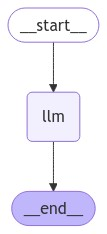

In [6]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Build the graph
builder:StateGraph = StateGraph(MessagesState)

# Add the node that calls the Gemini model with tools
builder.add_node("llm", llm)

# Define the flow of the conversation
builder.add_edge(START, "llm")  # Start with the tool-calling node
builder.add_edge("llm", END)    # End the conversation after generating a response

# Compile the graph
graph:CompiledStateGraph = builder.compile()

# Display the graph structure as a diagram
display(Image(graph.get_graph().draw_mermaid_png()))

## **Invoke The Graph:**

Let's invoke the graph with a simple conversation

In [7]:
from pprint import pprint
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

messages = graph.invoke({"messages":HumanMessage(content="Hello there, What's up")})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello there, What's up
================================== Ai Message ==================================

Hello! Not much, just hanging out in the digital world, waiting to be helpful. What about you? What's going on in your world today?


In [8]:
messages = graph.invoke({"messages":HumanMessage(content="Multiply 15 and 8")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 15 and 8
================================== Ai Message ==================================

15 multiplied by 8 is 120.
